In [71]:
import astropy
import astropy.coordinates as coo
from astropy.time import Time
from astropy.table import Table, Column
import astropy.units as u
import astroplan
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
import healpy as hp
from matplotlib.backends.backend_pdf import PdfPages

In [72]:
#!/usr/bin/env python3
import astropy
import astropy.coordinates as coo
from astropy.time import Time
from astropy.table import Table, Column
import astropy.units as u
import astroplan
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
import healpy as hp
from matplotlib.backends.backend_pdf import PdfPages


def make_grid(nside=128):
    """
    Create a grid of tiles on the entire sky, and return RA, Dec
    Make it a table, so that later rise and set times can be included in the same thing.

    For GIT we select a healpix grid, with inter-pixel separation 0.46 degrees (nside = 128)
    """
    npix = hp.nside2npix(nside)
    pixels = np.arange(npix)
    ra, dec = hp.pix2ang(nside, pixels, lonlat=True)
    return ra * u.deg, dec * u.deg


def grid2targets(ra, dec):
    """
    Take RA and Dec (astropy quantities) and return a list of targets usable by astroplan
    """
    target_list = []
    for i in range(len(ra)):
        target_list.append(astroplan.FixedTarget(coord=coo.SkyCoord(ra[i], dec[i]),
                                                 name="tile_{}".format(i)))
    return target_list


def get_probabilities(skymap, ra, dec, radius=0.35*u.deg):
    """
    Compute the probabilities covered in a grid of ra, dec with radius
    given a healpix skymap

    Note: this radius is such that for the default sky grid (nside=128),
    fields overlap such that the area of the sky becomes 1.83 * 4pi steradians.
    As a result, the sum of probabilities will be 1.83
    """
    # fact : int, optional
    # Only used when inclusive=True. The overlapping test will be done at
    # the resolution fact*nside. For NESTED ordering, fact must be a power of 2, less than 2**30,
    # else it can be any positive integer. Default: 4.
    fact = 1
    nside_skymap = hp.npix2nside(len(skymap))
    tile_area = np.pi * radius.to(u.deg).value ** 2
    pixel_area = hp.nside2pixarea(nside_skymap, degrees=True)
    probabilities = np.zeros(len(ra))
    vecs = hp.ang2vec(ra.to(u.deg).value, dec.to(u.deg).value, lonlat=True)
    for i in range(len(ra)):
        sel_pix = hp.query_disc(nside_skymap, vecs[i], radius.to(
            u.rad).value, inclusive=True, fact=fact)
        probabilities[i] = np.sum(skymap[sel_pix]) * \
            tile_area / pixel_area / len(sel_pix)
    return probabilities


def get_obs_times(observatory=astroplan.Observer.at_site("iao"),
                  exptime=5*u.min, start_time=None, end_time=None):
    """
    Make a list of observing times
    """
    if start_time is None:
        start_time = observatory.twilight_evening_civil(Time.now(), 'next')
    if end_time is None:
        end_time = observatory.twilight_morning_civil(start_time, 'next')
    return np.arange(start_time, end_time, exptime)


def get_top_tiles(ra, dec, probabilities, frac=0.95):
    """
    probabilities may not add up to 1
    return indices of tiles that add up to frac of total
    """
    sortorder = np.argsort(probabilities)
    p_cum = np.cumsum(probabilities[sortorder]) / np.sum(probabilities)
    startind = np.where(p_cum > 1 - frac)[0][0]
    top_tiles = sortorder[startind:]
    return top_tiles


def vis2cost(visibility, probabilities, costmax=None):
    """
    Given n_tiles * n_times array of visibility and n_tiles array of probabilities, return a cost array
    """
    maxweight = np.max(probabilities)
    if costmax is None:
        costmax = 10000 * maxweight
    weights = visibility * probabilities[:, None]
    cost = maxweight - weights
    cost[~visibility] = costmax
    return cost


def save_table(times, tiles, probabilities, prob_scaling, style='csv', filename="schedule.csv"):
    """
    Filename should include extension.
    """

    final_table = Table(names=("mjdobs", "obstime", "ra", "dec", "prob", "p_unscaled", "id"),
                        dtype=(np.float32, 'S23', np.float32, np.float32, np.float32, np.float32, 'S10'))
    for count in range(len(tiles)):
        this_tile = tiles[count]
        this_time = times[count]
        this_prob = probabilities[count]
        final_table.add_row((this_time.mjd, this_time.isot,
                             this_tile.ra, this_tile.dec,
                             this_prob/prob_scaling, this_prob, this_tile.name))
    final_table.sort('mjdobs')
    final_table.add_column(
        Column(data=np.arange(len(final_table)), name='num'), 0)

    if style == 'csv':
        final_table.write(filename)
    else:
        print("Unknown save style... table not saved")

    return final_table


def cleanup_obs(visibility, prob_top, tile_list, obs_times):
    """
    Delete times when no tiles are visible
    visibility: 2d numpy array size (t,w)
    prob_top: numpy array of length t
    obs_times: numpy array of length w
    tile_list: list of 'target' objects, length t
    """
    times_visible = np.where(np.sum(visibility, axis=0) > 0)[0]
    tiles_visible = np.where(np.sum(visibility, axis=1) > 0)[0]

    out_vis = visibility[tiles_visible, :][:, times_visible]
    out_times = obs_times[times_visible]
    out_prob = prob_top[tiles_visible]
    out_tile = [tile_list[i]
                for i in range(len(tile_list)) if i in tiles_visible]
    return out_vis, out_prob, out_tile, out_times


def visualize_results(skymap, pmax, final_table, sitename, plotfilename='schedule_visualize.pdf'):
    """
    Make the following plots:
    Altitude, azimuth v/s time, coloured by p
    RA, dec v/s time, coloured by p
    alt v/s az, coloured by p, at: risetime, settime, midtime
    """
    site = coo.EarthLocation.of_site(sitename)
    times = Time(final_table['mjdobs'], format='mjd')
    radec = coo.SkyCoord(final_table['ra']*u.deg, final_table['dec']*u.deg)
    altaz = radec.transform_to(coo.AltAz(obstime=times, location=site))

    sky_cum = np.cumsum(np.sort(skymap)[::-1])
    all_sky = 360.**2/np.pi
    areas = np.linspace(0, all_sky, len(skymap))
    fracs_desired = np.array([0.5, 0.9, 0.95])
    areas_desired = np.interp(fracs_desired, sky_cum, areas)
    mesg = 'Areas: '
    for f, a in zip(fracs_desired, areas_desired):
        mesg = mesg + "{:.0f}%: {:.0f}, ".format(f*100, a)
    mesg = mesg + "sq deg"
    prob_cov = np.sum(final_table['prob'])

    plotfile = PdfPages(plotfilename)
    fig = plt.figure()
    hp.mollview(skymap, fig=fig.number, cmap="Oranges", min=0,
                title="Max observable probability = {:.0f}%, covered ~ {:.0f}%\n{}".format(pmax*100, prob_cov*100, mesg))
    hp.graticule()
    for ra in [0, 6, 12, 18]:
        hp.projtext(ra*15, 0, r"{}$^h$".format(ra), lonlat=True)
    for dec in [-90, -60, -30, 30, 60, 90]:
        hp.projtext(180, dec, r"{}$^\circ$".format(dec), lonlat=True)
    plotfile.savefig()
    plt.close(fig)

    fig = plt.figure()
    upper = plt.subplot(211)
    plt.scatter(times.mjd, altaz.alt, c=final_table['prob'])
    plt.title("Altitudes of observed targets")
    plt.colorbar()
    plt.subplot(212, sharex=upper)
    plt.scatter(times.mjd, altaz.az, c=final_table['prob'])
    plt.title("Azimuths of observed targets")
    plt.colorbar()
    plt.subplots_adjust(hspace=0.3)
    plotfile.savefig()
    plt.close(fig)

    fig = plt.figure()
    upper = plt.subplot(211)
    plt.scatter(times.mjd, final_table['ra'], c=final_table['prob'])
    plt.title("RA of observed targets")
    plt.colorbar()
    plt.subplot(212, sharex=upper)
    plt.scatter(times.mjd, final_table['dec'], c=final_table['prob'])
    plt.title("Dec of observed targets")
    plt.colorbar()
    plt.subplots_adjust(hspace=0.3)
    plotfile.savefig()
    plt.close(fig)

    fig = plt.figure()
    plt.plot(final_table['ra'], final_table['dec'],
             color='black', alpha=0.15, lw=1)
    plt.scatter(final_table['ra'], final_table['dec'],
                c=final_table['prob'], label="Probability")
    plt.gca().set_aspect(1)
    plt.title("Observing sequence")
    plt.colorbar()
    plt.legend()
    plotfile.savefig()
    plt.close(fig)

    fig = plt.figure()
    plt.plot(final_table['ra'], final_table['dec'],
             color='black', alpha=0.15, lw=1)
    plt.scatter(final_table['ra'], final_table['dec'],
                c=final_table['num'], label="Obs Num")
    plt.gca().set_aspect(1)
    plt.title("Observing sequence")
    plt.colorbar()
    plt.legend()
    plotfile.savefig()
    plt.close(fig)

    def _add_altaz_plot(time, titleword):
        altaz = radec.transform_to(coo.AltAz(obstime=time, location=site))
        fig = plt.figure()
        plt.scatter(altaz.az, altaz.alt,
                    c=final_table['prob'], label="Probability")
        plt.gca().set_aspect(1)
        plt.colorbar()
        plt.legend()
        plt.title("Altitude and azimuth at {}\n{}".format(titleword, time.iso))
        plotfile.savefig()
        plt.close(fig)
        fig = plt.figure()
        plt.scatter(altaz.az, altaz.alt, c=final_table['num'], label="Obs Num")
        plt.gca().set_aspect(1)
        plt.colorbar()
        plt.legend()
        plt.title("Altitude and azimuth at {}\n{}".format(titleword, time.iso))
        plotfile.savefig()
        plt.close(fig)

    tstart = Time(final_table['mjdobs'][0], format='mjd')
    _add_altaz_plot(tstart, "start of observations")

    indexmid = int(len(final_table)/2)
    tmid = Time(final_table['mjdobs'][indexmid], format='mjd')
    _add_altaz_plot(tmid, "middle of observations")

    tend = Time(final_table['mjdobs'][-1], format='mjd')
    _add_altaz_plot(tend, "end of observations")

    plotfile.close()


def masked_map(skymap, decmin=45.4, decmax=47.4, verbose=True):
    npix = len(skymap)
    nside = hp.npix2nside(npix)
    indices = np.arange(npix)
    rapix, dpix = hp.pix2ang(nside, indices, lonlat=True)
    mask = (dpix >= decmin) & (dpix <= decmax)
    skymap[~mask] = 0
    ptot = np.sum(skymap)
    print("Probability after masking = ", np.sum(skymap))
    skymap /= ptot
    return skymap


def tilefilter(ra, dec, ref_file="obs_20190426.csv", tolerance=1*u.arcmin):
    """
    Exclude any ra-dec that are present in the ref file
    ** PROBLEM ** - this breaks TILE_ID which should be sacred
    """
    reftab = Table.read(ref_file)
    radec_ref = coo.SkyCoord(reftab['ra']*u.deg, reftab['dec']*u.deg)
    radec_grid = coo.SkyCoord(ra, dec)
    match_id, sep2d, sep3d = radec_grid.match_to_catalog_sky(radec_ref)
    rejmask = (sep2d < tolerance)
    radec_sel = radec_grid[~rejmask]
    return radec_sel.ra, radec_sel.dec


def opt_schedule(filename, sitename, outfile, plotfile, verbose, airmass_max, alt_min, alt_max,
                 start_time=None, end_time=None, exptime=10.5*u.min,
                 apply_tilefilter=False, apply_mask=False):
    """
    Calculate optimal schedule for a given healpix map, date, and site
    """

    if verbose:
        print("Creating observatory grid and observing times...")
    ra, dec = make_grid()

    # # Grid A:
    # ra = ra[::2]
    # dec = dec[::2]

    # # Grid B
    # ra = ra[1::2]
    # dec = dec[1::2]

    # if apply_tilefilter:
    #     ra, dec = tilefilter(ra, dec)
    #     # ** PROBLEM ** - this breaks TILE_ID which should be sacred

    iao = astroplan.Observer.at_site(sitename)
    obs_times = get_obs_times(iao, exptime=exptime)

    if verbose:
        print("Reading skymap")
    skymap = hp.read_map(filename)
    # Fudge: set skymap to zero below dec=80
    if apply_mask:
        skymap = masked_map(skymap)

    if verbose:
        print("Calculating probabilities of tiles and selecting top tiles")
    probabilities = get_probabilities(skymap, ra, dec)
    prob_scaling = np.sum(probabilities)
    top_tiles = get_top_tiles(ra, dec, probabilities, frac=0.95)
    tile_list = grid2targets(ra[top_tiles], dec[top_tiles])
    prob_top = probabilities[top_tiles]

    if verbose:
        print("Calculating visibility and discarding blank slots/unobservable tiles")
    constraints = [astroplan.AltitudeConstraint(alt_min*u.deg, alt_max*u.deg),
                   astroplan.AirmassConstraint(airmass_max),
                   astroplan.AtNightConstraint.twilight_nautical()]
    visibility = astroplan.is_event_observable(
        constraints, iao, tile_list, obs_times)

    # Variables used below: visibility, prob_top, tile_list, obs_times
    clean_visibility, clean_prob_top, clean_tile_list, clean_obs_times = cleanup_obs(
        visibility, prob_top, tile_list, obs_times)
    pmax = np.sum(clean_prob_top)/prob_scaling
    if pmax == 0:
        if verbose:
            print("No tiles are visible")
        return

    if verbose:
        print("Calculating optimal cost")
    cost_array = vis2cost(clean_visibility, clean_prob_top)
    index_tiles, index_times = linear_sum_assignment(cost_array)

    if verbose:
        print("Saving output to {}".format(outfile))
    final_times = clean_obs_times[index_times]
    final_tiles_objects = [clean_tile_list[i]
                           for i in range(len(clean_tile_list)) if i in index_tiles]
    final_probabilities = clean_prob_top[index_tiles]
    final_table = save_table(final_times, final_tiles_objects,
                             final_probabilities, prob_scaling, filename=outfile)

    if verbose:
        print("Plotting results to {}".format(plotfile))
    visualize_results(skymap, pmax, final_table,
                      sitename, plotfilename=plotfile)

    if verbose:
        print("Done")
        

In [ ]:
if __name__ == "__main__":
    filename = "glg_healpix_all_bn190626526.fit"
    sitename = 'iao'
    outfile = "glg_healpix_all_bn190626526.csv"
    plotfile = "glg_healpix_all_bn190626526.pdf"
    verbose = True
    airmass_max = 4
    alt_min = 20
    alt_max = 85
    start_time = None
    end_time = None
    exptime = 10.5*u.min
    apply_mask = False  # mask parameters to be defined in masked_map
    apply_tilefilter = False

    opt_schedule(filename, sitename, outfile, plotfile, verbose,
                 airmass_max, alt_min, alt_max, start_time, end_time, exptime,
                 apply_mask, apply_tilefilter)


In [80]:
galaxies = np.loadtxt("maincat.csv",unpack=True,delimiter=",")
gra = galaxies[0]
gdec = galaxies[1]
gman = galaxies[2]

In [79]:
galaxies

array([[ 33.29255556,  49.25122222,  51.16955556, ...,  52.57133333,
         45.86733333,  27.18422222],
       [-84.85444444, -78.27388889, -76.41638889, ...,  78.93694444,
         78.99138889,  80.12388889],
       [ 15.13      ,  13.65      ,  18.        , ...,  14.75      ,
         14.27      ,  16.4       ]])

In [74]:
ra,dec = make_grid()

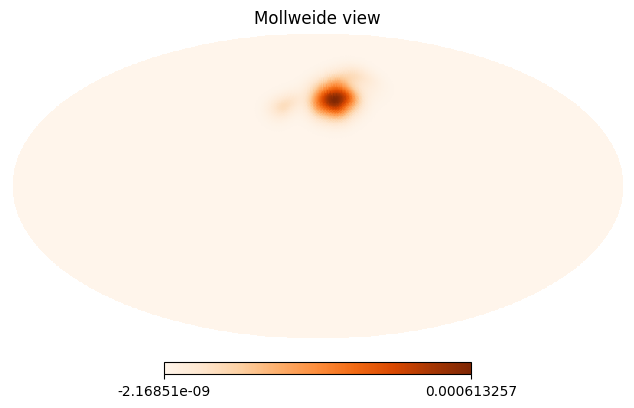

In [112]:
filename = "glg_healpix_all_bn230201236.fit"
skymap = hp.read_map(filename)
fig = plt.figure()
hp.mollview(skymap, fig=fig.number, cmap="Oranges")
probabilities = get_probabilities(skymap, ra, dec)
#print(ra[0])

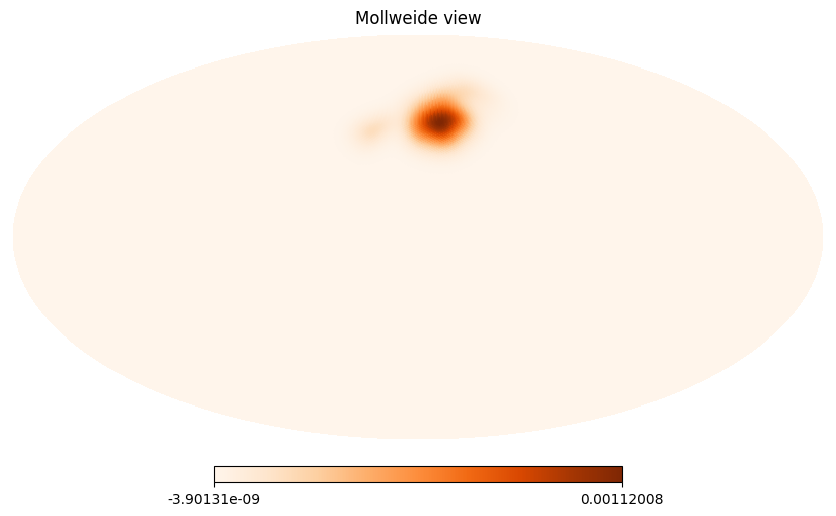

In [113]:
hp.mollview(probabilities, fig=fig.number, cmap="Oranges")

2416


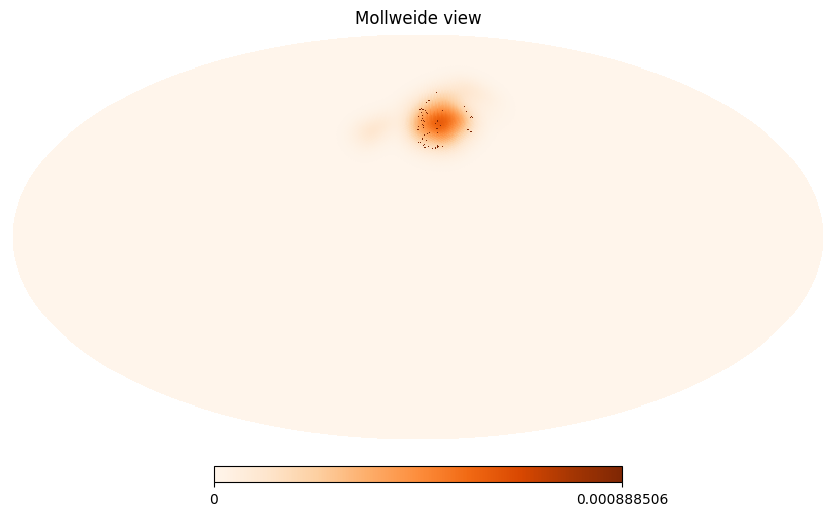

In [136]:
#probabilities = get_probabilities(skymap, ra, dec)

def galaxy_increase_prob(probabilities, galaxy_tiles  = [], nums = [], NSIDE = 128):
    region = np.where(probabilities > np.max(probabilities)/5)
    print(len(region[0]))
    
    if len(galaxy_tiles) == 0:
        for i in range(len(gra)):
            tilenum = hp.pixelfunc.ang2pix(NSIDE,np.radians(-gdec[i]+90.),np.radians(360.-gra[i]))
            #print(tilenum, len(region[0]))
            
            if tilenum in region[0]:
                galaxy_tiles.append(tilenum)
    
    new_probs = np.copy(probabilities)
    if len(nums) == 0:
        new_probs[galaxy_tiles] = np.max(new_probs)*1.5
    else:
        new_probs[galaxy_tiles] = nums
    new_probs[np.where(new_probs < 0)] = 0
    new_probs /= np.sum(new_probs)
    return new_probs

n = galaxy_increase_prob(probabilities)

hp.mollview(n, fig=fig.number, cmap="Oranges")

In [141]:
def remove_observed_tiles(probabilities, observed_tiles):
    new_probs = np.copy(probabilities)
    new_probs[observed_tiles] = np.min(probabilities)
    new_probs[np.where(new_probs < 0)] = 0
    new_probs /= np.sum(new_probs)
    return new_probs

In [157]:
observed = [i for i in range(20181,21000)]

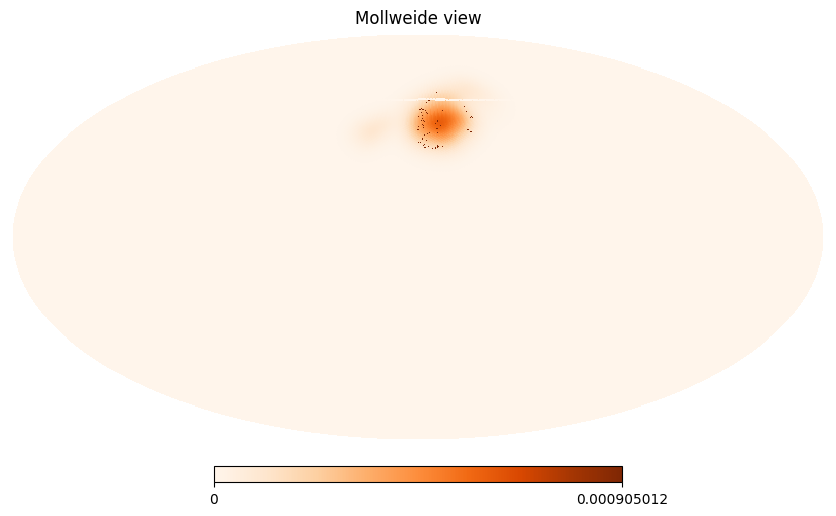

In [158]:
probabilities = get_probabilities(skymap, ra, dec)
m = remove_observed_tiles(n, observed)

hp.mollview(m, fig=fig.number, cmap="Oranges")